In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return torch.relu(out)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = ResidualBlock(64, 128, stride=2)
        self.layer2 = ResidualBlock(128, 256, stride=2)
        self.layer3 = ResidualBlock(256, 512, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [3]:
def softmax_with_temperature(logits, T):
    """Apply softmax with temperature scaling."""
    return F.softmax(logits / T, dim=1)

class DistillationLoss(nn.Module):
    """Knowledge Distillation Loss using KL Divergence."""
    def __init__(self, T):
        super(DistillationLoss, self).__init__()
        self.T = T

    def forward(self, student_logits, teacher_probs):
        student_probs = F.log_softmax(student_logits / self.T, dim=1)
        return F.kl_div(student_probs, teacher_probs, reduction="batchmean") * (self.T ** 2)

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train, batch_size=64, shuffle=True)

test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 49.0MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model = CNN().to(device)
optimizer = optim.Adam(teacher_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 30
print("Training Teacher Model...")
for epoch in range(num_epochs):
    teacher_model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = teacher_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

torch.save(teacher_model.state_dict(), "/kaggle/working/teacher_model.pth")
print("Teacher Model Trained & Saved.")

In [9]:
teacher_model.load_state_dict(torch.load("/kaggle/input/cifar10-cnn-residual/pytorch/default/1/cifar10_cnn.pth", weights_only=True))

<All keys matched successfully>

In [10]:
T = 5.0  
teacher_model.eval()

soft_labels_list = []
with torch.no_grad():
    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        logits = teacher_model(inputs)
        soft_labels_list.append(softmax_with_temperature(logits, T))

soft_labels = torch.cat(soft_labels_list)  
print("Soft Labels Generated.")

Soft Labels Generated.


In [ ]:
student_model = CNN().to(device)
optimizer = optim.Adam(student_model.parameters(), lr=0.001)
criterion = DistillationLoss(T)

print("Training Student Model...")
for epoch in range(20):
    student_model.train()
    total_loss = 0
    correct = 0
    total = 0

    for (inputs, labels), soft_targets in zip(train_loader, soft_labels):
        inputs, labels, soft_targets = inputs.to(device), labels.to(device), soft_targets.to(device)
        
        optimizer.zero_grad()
        student_logits = student_model(inputs)
        loss = criterion(student_logits, soft_targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(student_logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.2f}%")

torch.save(student_model.state_dict(), "/kaggle/working/student_model.pth")
print("Student Model Trained & Saved.")

Training Student Model...
Epoch 1: Loss = 22.0772, Accuracy = 10.16%
Epoch 2: Loss = 21.9069, Accuracy = 9.99%
Epoch 3: Loss = 21.8455, Accuracy = 9.92%
Epoch 4: Loss = 21.8186, Accuracy = 9.89%
Epoch 5: Loss = 21.8176, Accuracy = 10.01%
Epoch 6: Loss = 21.8024, Accuracy = 9.63%
Epoch 7: Loss = 21.7953, Accuracy = 9.76%


In [6]:
import random

target_class = torch.tensor([9], dtype=torch.long, device="cuda")
model = model.to("cuda")
model.eval()
c = 0
l = 0
for i in range(100):
    j = random.randint(1, len(train))
    input_image = train[j][0].unsqueeze(0).to("cuda")
    input_image = input_image.detach().clone()
    input_image.requires_grad_(True)
    output = model(input_image)
    loss = -torch.nn.functional.cross_entropy(output, target_class)

    model.zero_grad()
    loss.backward()

    with torch.no_grad():
        input_image += 0.1 * input_image.grad.sign()
        input_image.clamp_(0, 1)
    input_image.grad.zero_()
    a = model(input_image)
    pred = torch.argmax(torch.nn.functional.softmax(a, dim=1)).item()
    if pred == train[j][1]:
        c += 1
    l += loss.item()
print(c / 100)
print("average loss", l / 100)

0.06
average loss -2.535644779205322


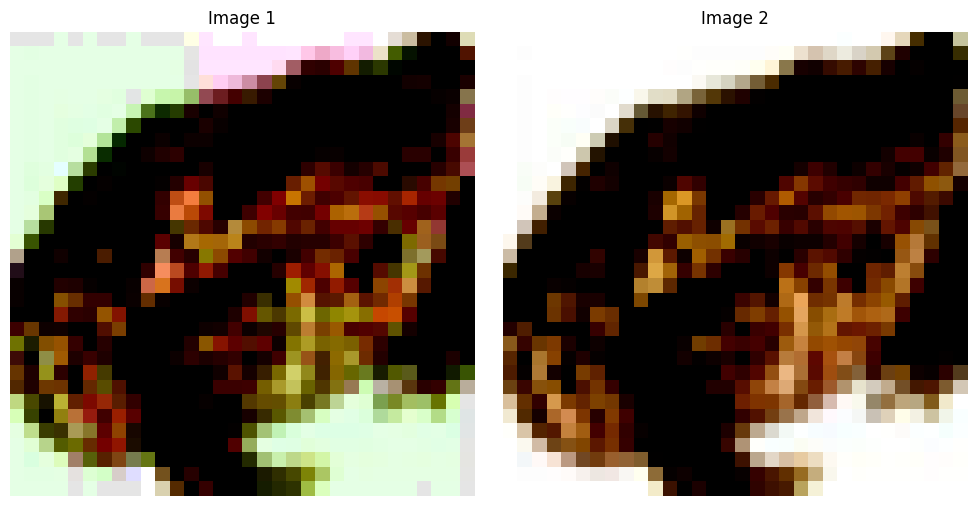

In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(input_image.detach().cpu()[0].permute(1, 2, 0).numpy())
axes[0].axis('off')
axes[0].set_title("Image 1")

axes[1].imshow(np.transpose(train[j][0], (1, 2, 0)))
axes[1].axis('off')
axes[1].set_title("Image 2")

plt.tight_layout()
plt.show()

In [ ]:
plt.imshow(input_image.detach().cpu()[0].permute(1, 2, 0) - np.transpose(train[j][0], (1, 2, 0)))
plt.show()